<a href="https://www.kaggle.com/code/eniseyerkazan/akbank?scriptVersionId=264136883" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

kütüphaneler

# Kütüphanelerin İçe Aktarılması

Bu hücrede proje için gerekli Python kütüphaneleri içe aktarılmıştır.Gerekli kütüphaneler hazır hale getirilinir ve sonraki adımlarda veri işleme, model tanımı ve eğitimi sorunsuz şekilde yapılabilir.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import time
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2025-09-26 11:20:25.454424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758885625.798116      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758885625.895859      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Veri Yükleme ve Ön İşleme

Bu hücrede veri seti Kaggle’dan yüklenir ve eğitim/doğrulama setleri oluşturulur.

- `img_size = (128,128)`: Tüm görüntüler bu boyuta yeniden boyutlandırılır.  
- `batch_size = 32`: Her eğitim adımında 32 görüntü kullanılır.  
- `label_mode='binary'`: Binary sınıflandırma (0 = no tumor, 1 = tumor).  
- `validation_split=0.2`: Verinin %20’si doğrulama için ayrılır.  
- `AUTOTUNE`: Performans için veri önbellekleme ve prefetch yapılır.  

> Bu adım, modelin eğitimine uygun şekilde veriyi hazırlar.


In [2]:
data_dir = "../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',          # 0 = no, 1 = yes
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

class_names = train_ds.class_names
print("Sınıflar:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.
Sınıflar: ['no', 'yes']


2025-09-26 11:20:44.203449: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Veri Görselleştirme

Eğitim setinden rastgele 9 görüntü seçilir ve görselleştirilir.  

- Görsellerin başlıkları sınıf adını gösterir.  
- Bu adım veri seti hakkında görsel bilgi verir ve sınıf dağılımını anlamaya yardımcı olur.

> Görselleştirme ile veri kalitesini ve çeşitliliğini kontrol etmiş oluruz.


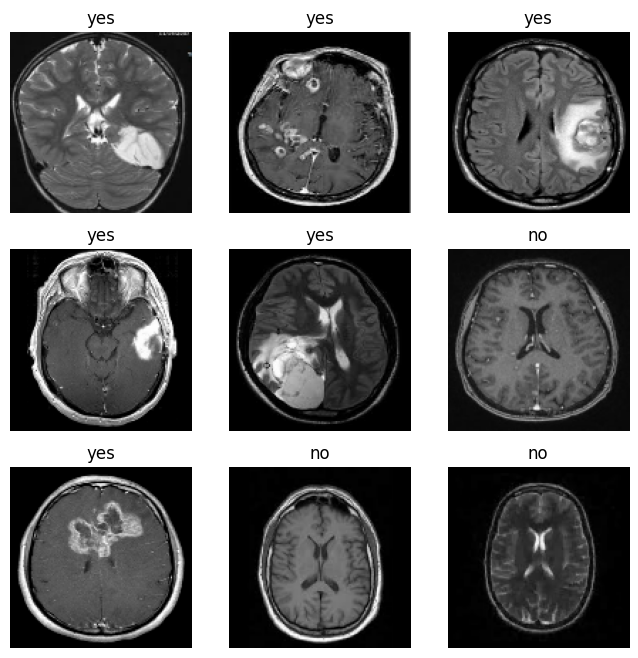

In [3]:
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()

# CNN Model Tanımı

- **Rescaling**: Görüntüler 0-1 aralığına normalize edilir.  
- **Conv2D + MaxPooling2D**: Görüntüden özellik çıkarımı yapılır.  
- **Flatten**: 2D feature map 1D vektöre çevrilir.  
- **Dense + Dropout**: Fully connected katman ile sınıflandırma yapılır, dropout ile overfitting azaltılır.  
- **Output Layer**: 1 nöron ve sigmoid aktivasyon ile binary sınıflandırma yapılır.  

Model, **adam optimizasyon algoritması**, `binary_crossentropy` kayıp fonksiyonu ve `accuracy`, `precision`, `recall` metrikleri ile derlenir.

> Bu hücre model mimarisini ve eğitim için gerekli parametreleri tanımlar.


In [4]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # binary output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

# Model Eğitimi

Model 15 epoch boyunca eğitim seti üzerinde eğitilir.  

- `train_ds` ile eğitim, `val_ds` ile doğrulama yapılır.  
- Eğitim süreci `history` değişkenine kaydedilir.  

> Bu adım sonunda model, beyin MR görüntülerinde tümör olup olmadığını tahmin edecek şekilde optimize edilir.


In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 716ms/step - accuracy: 0.5366 - loss: 0.7057 - precision: 0.6068 - recall: 0.7398 - val_accuracy: 0.7000 - val_loss: 0.6224 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - accuracy: 0.7535 - loss: 0.5942 - precision: 0.7234 - recall: 0.9283 - val_accuracy: 0.7400 - val_loss: 0.5198 - val_precision: 0.7500 - val_recall: 0.9091
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.7703 - loss: 0.5500 - precision: 0.7916 - recall: 0.8595 - val_accuracy: 0.7200 - val_loss: 0.5224 - val_precision: 0.7317 - val_recall: 0.9091
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - accuracy: 0.7866 - loss: 0.5246 - precision: 0.7778 - recall: 0.9207 - val_accuracy: 0.8000 - val_loss: 0.5131 - val_precision: 0.8485 - val_recall: 0.8485
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - accuracy: 0.8160 - loss: 0.4608 - precision: 0.8271 - recall: 0.8881 - val_accuracy: 0.8000 - val_loss: 0.5035 - val

# Model Değerlendirme

**Doğruluk Kontrolü:**

- Son epoch’daki eğitim ve doğrulama doğrulukları yazdırılır.  

**Confusion Matrix:**

- Modelin tahmin ettiği sınıflar ile gerçek sınıflar karşılaştırılır.  
- `heatmap` ile görselleştirilir.  
- `classification_report` ile precision, recall ve F1-score hesaplanır.

> Bu adım modelin hangi sınıflarda başarılı olduğunu ve nerelerde hata yaptığını gösterir.  
> Overfitting veya underfitting durumu grafik ve değerlerle yorumlanabilir.


Son epoch - Eğitim Doğruluğu: 0.941, Doğrulama Doğruluğu: 0.780
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


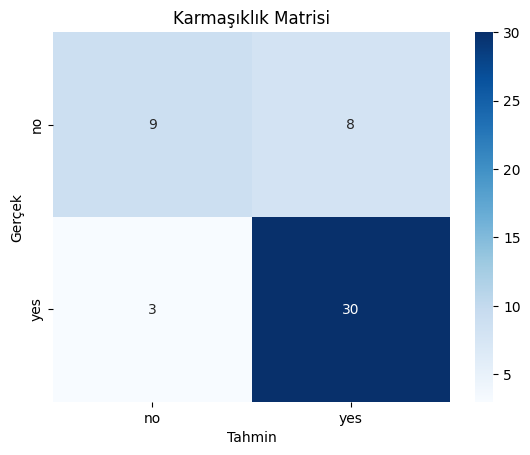

              precision    recall  f1-score   support

          no       0.75      0.53      0.62        17
         yes       0.79      0.91      0.85        33

    accuracy                           0.78        50
   macro avg       0.77      0.72      0.73        50
weighted avg       0.78      0.78      0.77        50



In [6]:
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Son epoch - Eğitim Doğruluğu: {acc:.3f}, Doğrulama Doğruluğu: {val_acc:.3f}")

y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy().astype(int).flatten())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# Kaggle Dataset Yolu ve Sınıfların Belirlenmesi

- `data_dir`: Kaggle veri setinin yolu.  
- `classes`: Veri klasöründeki alt klasörler kullanılarak sınıflar otomatik olarak belirlenir (örneğin `no_tumor` ve `tumor`).  

> Bu adım ile modelin tahmin edeceği sınıflar belirlenir ve görüntüleri bu sınıflara göre etiketleyebiliriz.


In [7]:
data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

#  Görüntülerin Yüklenmesi ve Etiketlenmesi

- Her sınıf klasörü içinde döngü ile tüm görüntüler yüklenir (`load_img`) ve `img_to_array` ile NumPy dizisine çevrilir.  
- `images` listesi tüm görüntüleri, `labels` listesi ise karşılık gelen sınıf etiketlerini tutar.  

> Bu adım, ham görüntü verilerini modelin anlayabileceği formata dönüştürür.


In [8]:
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
print("Sınıflar:", classes)

images = []
labels = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(cls_folder):
        img_path = os.path.join(cls_folder, img_name)
        # Sadece dosya olanları yükle
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=(150,150))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(idx)

Sınıflar: ['no', 'yes']


# NumPy Dizilerine Çevirme ve Eğitim/Test Seti Oluşturma

- `x` ve `y` NumPy dizilerine çevrilir.  
- `train_test_split` ile veriler %80 eğitim ve %20 test olarak ayrılır.  
- `stratify=y` ile sınıf dağılımı korunur.  

> Bu adım, modelin eğitim ve test performansını değerlendirmek için veriyi hazırlar.


In [9]:
x = np.array(images)
y = np.array(labels)

# Normalizasyon ve One-hot Encoding

- Görüntü verileri `0-1` aralığına normalize edilir (`/255`).  
- Etiketler `to_categorical` ile one-hot encoding formatına çevrilir.  
- `num_classes`: Sınıf sayısı belirlenir.  

> Normalizasyon ve one-hot encoding, modelin daha hızlı ve doğru öğrenmesini sağlar.


In [10]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

num_classes = len(classes)
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# Veri Artırma (Data Augmentation)

- `ImageDataGenerator` kullanılarak veri artırma uygulanır:  
  - `rotation_range=15` → Görüntüler 15 dereceye kadar döndürülebilir  
  - `width_shift_range=0.1`, `height_shift_range=0.1` → Görüntüleri yatay/dikey kaydırma  
  - `horizontal_flip=True` → Görüntüleri yatay çevirme  
  - `zoom_range=0.1` → Görüntüleri %10 oranında yakınlaştırma  

```python
datagen.fit(x_train)


In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

print("Normalize edilmiş eğitim verisi şekli:", x_train.shape)
print("One-hot encoded edilmiş eğitim verisi şekli:", y_train_categorical.shape)

Normalize edilmiş eğitim verisi şekli: (202, 150, 150, 3)
One-hot encoded edilmiş eğitim verisi şekli: (202, 2)


# CNN Modelinin Oluşturulması

Bu hücrede, **çok katmanlı bir CNN (Convolutional Neural Network) modeli** tanımlanıyor.

## Modelin Yapısı:

### Konvolüsyon Bloğu 1
- `Conv2D(32, (3,3), activation='relu', padding='same')`: İlk 2D konvolüsyon katmanı, 32 filtre ve ReLU aktivasyonu ile özellik çıkarımı yapar.
- `BatchNormalization()`: Aktivasyonları normalize ederek öğrenmeyi hızlandırır ve overfitting’i azaltır.
- `MaxPooling2D((2,2))`: Özellik haritasını küçülterek boyutları düşürür.
- `Dropout(0.2)`: Rastgele nöronları kapatarak overfitting’i önler.

### Konvolüsyon Bloğu 2
- `Conv2D(64, ...)` ve `BatchNormalization()`: Daha derin özellikleri öğrenir.
- `MaxPooling2D((2,2))` ve `Dropout(0.3)`: Boyut azaltma ve regularization.

### Konvolüsyon Bloğu 3
- `Conv2D(128, ...)` ve `BatchNormalization()`: Daha karmaşık özellikleri öğrenir.
- `MaxPooling2D((2,2))` ve `Dropout(0.4)`: Boyut azaltma ve overfitting kontrolü.

### Fully Connected Katmanlar
- `Flatten()`: 2D feature map’i 1D vektöre dönüştürür.
- `Dense(128, activation='relu')` + `BatchNormalization()` + `Dropout(0.5)`: Sınıflandırma için yoğun katman ve overfitting azaltma.
- `Dense(num_classes, activation='softmax')`: Son katman, `softmax` aktivasyonu ile 4 sınıf için olasılık üretir.

> Bu yapı, **görüntüden özellik çıkarımı ve sınıflandırmayı** etkin şekilde yapacak şekilde tasarlanmıştır.

---

# Model Özeti

```python
cnn_model.summary()


In [12]:
def create_cnn_model(input_shape=(150,150,3), num_classes=4):
    model = models.Sequential([
        
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),  # yazım düzeltildi
        layers.Dense(num_classes, activation='softmax')  # sınıf sayısı 4
    ])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,597,476 (21.35 MB)

 Trainable params: 5,596,772 (21.35 MB)

 Non-trainable params: 704 (2.75 KB)

# Dataset Yolu ve Sınıfların Belirlenmesi

- `data_dir`: Kaggle veri setinin yolu.  
- `classes`: Veri klasöründeki alt klasörler kullanılarak sınıflar belirlenir (ör. `no_tumor` ve `tumor`).  

> Bu adım ile modelin tahmin edeceği sınıflar belirlenir.


In [13]:
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'

classes = os.listdir(data_dir)
print("Sınıflar:", classes)


Sınıflar: ['no', 'yes']


# Görüntülerin Yüklenmesi ve Normalizasyon

- Her sınıf klasörü içinde döngü ile tüm görüntüler yüklenir (`load_img`) ve `img_to_array` ile NumPy dizisine çevrilir.  
- Piksel değerleri `0-1` aralığına normalize edilir (`/255`).  

> Bu adım, modelin anlayabileceği formata veri hazırlamak için gereklidir.


In [14]:
images = []
labels = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(cls_folder):
        img_path = os.path.join(cls_folder, img_name)
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=(150,150))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(idx)

x = np.array(images, dtype='float32') / 255.0
y = np.array(labels)

# Eğitim ve Test Setine Ayırma

- `train_test_split` ile veriler %80 eğitim ve %20 test olarak ayrılır.  
- `stratify=y` ile sınıf dağılımı korunur.  

> Modelin doğruluk ve kaybını test seti üzerinde doğru değerlendirmek için gereklidir.


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Veri Artırma

- `ImageDataGenerator` kullanılarak veri artırma yapılır:  
  - `rotation_range=15`: Görüntüleri 15 dereceye kadar döndürme  
  - `width_shift_range`, `height_shift_range`: Yatay ve dikey kaydırma  
  - `horizontal_flip`: Yatay çevirme  
  - `zoom_range`: Yakınlaştırma  

```python
datagen.fit(x_train)


In [16]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)


# CNN Modeli Tanımı

- `Conv2D` + `MaxPooling2D` ile özellik çıkarımı yapılır.  
- `Flatten` ile 2D feature map 1D vektöre çevrilir.  
- `Dense` katmanları ile sınıflandırma yapılır.  
- Son katman `sigmoid` aktivasyonu ile binary output üretir.  

> Bu basit CNN modeli beyin MR görüntülerinde tümör olup olmadığını tahmin edecek şekilde tasarlanmıştır.


In [17]:
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(150,150,3)),
        layers.Conv2D(32,(3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64,(3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    return model

cnn_model = create_cnn_model()

# Model Derleme ve Callback’ler

- `optimizer='adam'` ve `loss='binary_crossentropy'` kullanılır.  
- `EarlyStopping`: Validation loss 10 epoch boyunca iyileşmezse durdurur ve en iyi ağırlıkları geri yükler.  
- `ReduceLROnPlateau`: Validation loss iyileşmezse learning rate’i düşürür.  

> Callback’ler overfitting’i önlemeye ve eğitim süresini optimize etmeye yardımcı olur.


In [18]:
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Model Eğitimi

- Model, augment edilmiş eğitim verisi ile `50 epoch` boyunca eğitilir.  
- `validation_data=(x_test, y_test)` ile doğrulama yapılır.  
- Eğitim süresi ölçülür ve yazdırılır.  

> Bu adım, modelin öğrenmesini ve doğrulama seti ile performansının izlenmesini sağlar.


In [19]:
start_time = time.time()
history = cnn_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 742ms/step - accuracy: 0.4720 - loss: 1.1866 - val_accuracy: 0.6275 - val_loss: 0.7743 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step - accuracy: 0.6624 - loss: 0.5962 - val_accuracy: 0.7451 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 721ms/step - accuracy: 0.7231 - loss: 0.5559 - val_accuracy: 0.7451 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 732ms/step - accuracy: 0.7757 - loss: 0.4855 - val_accuracy: 0.7255 - val_loss: 0.8008 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 743ms/step - accuracy: 0.7329 - loss: 0.6098 - val_accuracy: 0.7059 - val_loss: 0.7503 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 670ms/step - accuracy: 0.8358 - loss: 0.4803 - val_accuracy: 0.7451 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step - accuracy: 0.7958 - loss: 0.4738 - val_accuracy: 

# Eğitim ve Doğrulama Grafikleri

- `accuracy` ve `val_accuracy` grafikleri ile eğitim ve doğrulama doğruluğu izlenir.  
- `loss` ve `val_loss` grafikleri ile kayıp değerleri izlenir.  

> Bu grafikler overfitting/underfitting durumlarını yorumlamamıza yardımcı olur.


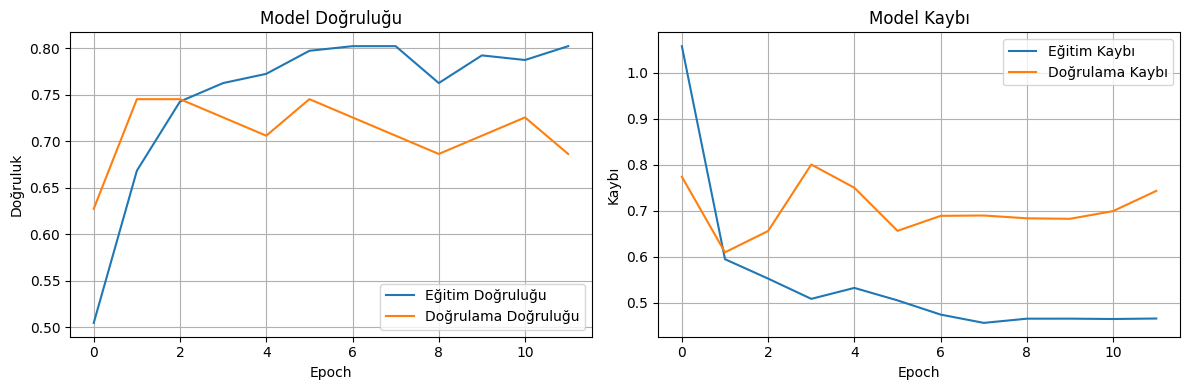

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kaybı')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Modelin Test Verisi Üzerinde Değerlendirilmesi

- `evaluate` ile test kaybı ve doğruluk hesaplanır.  
- `predict` ile test verisinin tahminleri alınır.  
- `classification_report` ile precision, recall ve F1-score hesaplanır.  
- `confusion_matrix` ile tahmin ve gerçek değerler karşılaştırılır ve heatmap ile görselleştirilir.  

> Bu adım, modelin gerçek dünya verisi üzerindeki performansını anlamamızı sağlar.


Test Kaybı: 0.6101
Test Doğruluğu: 0.7451
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

          no       0.71      0.60      0.65        20
         yes       0.76      0.84      0.80        31

    accuracy                           0.75        51
   macro avg       0.74      0.72      0.72        51
weighted avg       0.74      0.75      0.74        51



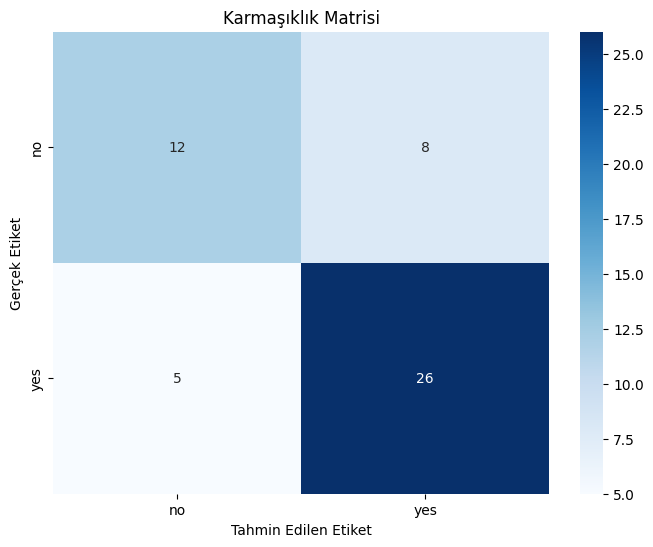

In [21]:

test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")


y_pred = (cnn_model.predict(x_test) > 0.5).astype("int32")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=classes))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()


# Veri Yükleme ve Ön İşleme

- `data_dir`: Kaggle veri setinin yolu.  
- `classes`: Sınıf isimleri (`no` = tümör yok, `yes` = tümör var).  
- Görüntüler `load_img` ile yüklenir ve `img_to_array` ile NumPy dizisine çevrilir.  
- Piksel değerleri 0-1 aralığına normalize edilir (`/255`).  
- `train_test_split` ile veriler %80 eğitim ve %20 test olarak ayrılır, `stratify=y` ile sınıf dağılımı korunur.  

> Modelin tahmin edeceği sınıflar ve eğitim/test setleri hazırlanır.


In [22]:
data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
classes = ["no", "yes"]
img_size = (150, 150)

images = []
labels = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(cls_folder):
        img_path = os.path.join(cls_folder, img_name)
        if os.path.isdir(img_path):  # klasörleri atla
            continue
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(idx)

X = np.array(images, dtype="float32") / 255.0
y = to_categorical(np.array(labels), num_classes=2)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# CNN Modeli

- `Conv2D` ve `MaxPooling2D` katmanları ile özellik çıkarımı yapılır.  
- `Flatten` ile 2D feature map 1D vektöre çevrilir.  
- `Dense(64, activation='relu')` ile yoğun katman oluşturulur.  
- `Dropout(0.5)` ile overfitting önlenir.  
- Son katman `Dense(2, activation='softmax')` ile iki sınıf için olasılık üretilir.  

> Bu model, beyin MR görüntülerinde tümör var/yok sınıflandırması yapmak için tasarlanmıştır.


In [23]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')    # ---- İKİ sınıf ----
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Derleme ve Eğitim

- `optimizer='adam'`, `loss='categorical_crossentropy'`, `metrics=['accuracy']`  
- Model 15 epoch boyunca eğitilir, `validation_split=0.2` ile doğrulama yapılır.  

> Bu adım, modelin öğrenmesini ve doğrulama performansını takip etmemizi sağlar.


In [24]:
cnn_model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2
)




Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 627ms/step - accuracy: 0.5737 - loss: 0.9786 - val_accuracy: 0.7805 - val_loss: 0.5214
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - accuracy: 0.8476 - loss: 0.4804 - val_accuracy: 0.7317 - val_loss: 0.6185
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - accuracy: 0.8664 - loss: 0.4194 - val_accuracy: 0.8049 - val_loss: 0.5069
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - accuracy: 0.8794 - loss: 0.3720 - val_accuracy: 0.7805 - val_loss: 0.5490
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 0.9072 - loss: 0.2474 - val_accuracy: 0.7805 - val_loss: 0.5310
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - accuracy: 0.9274 - loss: 0.1849 - val_accuracy: 0.8537 - val_loss: 0.4303
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.9363 - loss: 0.1922 - val_accuracy: 0.6829 - val_loss: 0.6427
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 0.8883 - loss: 0.2523 - val_accuracy: 0.8049 - val_loss:

# Test ve Değerlendirme

- `evaluate` ile test kaybı ve doğruluk ölçülür.  
- `predict` ile test verisinin tahminleri alınır.  
- `classification_report` ile precision, recall ve F1-score hesaplanır.  
- `confusion_matrix` ile tahmin ve gerçek değerler karşılaştırılır ve heatmap ile görselleştirilir.  

> Bu adım, modelin gerçek veri üzerindeki performansını anlamamıza yardımcı olur.


Test Kaybı: 1.3593
Test Doğruluğu: 0.7451
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

          no       0.77      0.50      0.61        20
         yes       0.74      0.90      0.81        31

    accuracy                           0.75        51
   macro avg       0.75      0.70      0.71        51
weighted avg       0.75      0.75      0.73        51



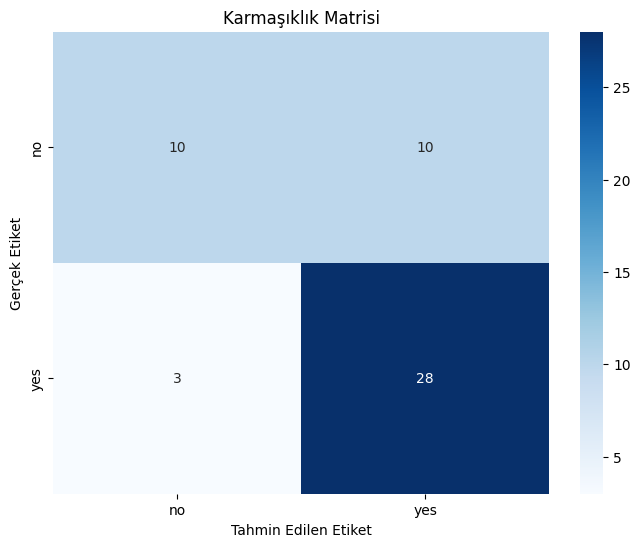

In [25]:
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")

y_pred = cnn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Doğru ve Yanlış Tahminlerin Görselleştirilmesi

- `correct_indices` ve `incorrect_indices` ile doğru ve yanlış tahminler belirlenir.  
- İlk 4 doğru ve yanlış örnek görselleştirilir.  
- Her görselde modelin tahmini ve gerçek etiketi gösterilir.  

> Bu görselleştirme, modelin hangi örneklerde başarılı veya başarısız olduğunu hızlıca anlamamızı sağlar.


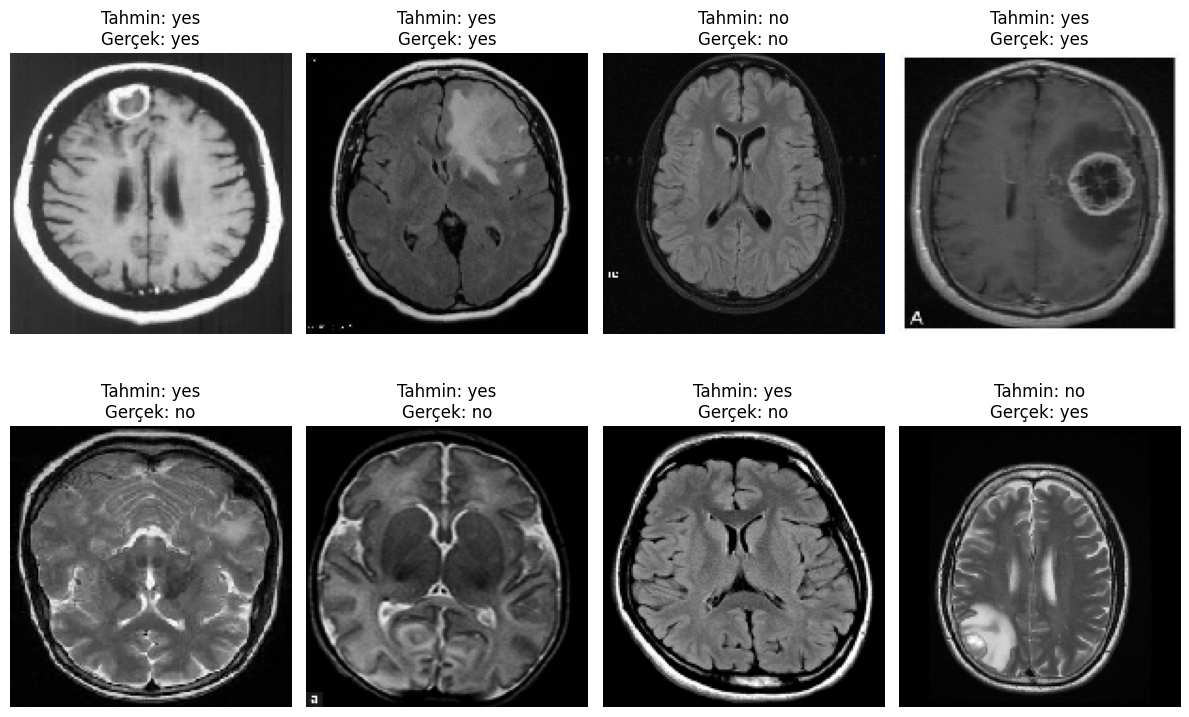

In [26]:
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12,8))

for i, idx in enumerate(correct_indices[:4]):
    plt.subplot(2,4,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"Tahmin: {classes[y_pred_classes[idx]]}\nGerçek: {classes[y_true[idx]]}")
    plt.axis('off')

for i, idx in enumerate(incorrect_indices[:4]):
    plt.subplot(2,4,i+5)
    plt.imshow(x_test[idx])
    plt.title(f"Tahmin: {classes[y_pred_classes[idx]]}\nGerçek: {classes[y_true[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Veri Yükleme ve ImageDataGenerator

- `ImageDataGenerator` ile rescaling (0-1 aralığına) ve `validation_split=0.2` yapılır.  
- `flow_from_directory` ile eğitim ve doğrulama jeneratörleri oluşturulur.  
- `class_mode='categorical'` ile etiketler one-hot kodlanır.  

> Bu adım, Kaggle veri setinden otomatik olarak eğitim ve doğrulama verilerini yüklememizi sağlar.


In [27]:
base_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',   # one-hot (2 kolon)
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# NumPy Dizilerine Çevirme

- `next(train_gen)` ve döngü ile tüm batch'ler birleştirilir.  
- Aynı işlem doğrulama seti için yapılır.  
- `np.argmax` ile one-hot etiketler 0/1 sınıf etiketlerine çevrilir.  

> Model eğitiminde kullanmak üzere tüm veri tek NumPy dizisinde birleştirilir.


In [28]:
x_train, y_train = next(train_gen)
for _ in range(len(train_gen)-1):
    x_batch, y_batch = next(train_gen)
    x_train = np.concatenate([x_train, x_batch])
    y_train = np.concatenate([y_train, y_batch])

x_test, y_test = next(val_gen)
for _ in range(len(val_gen)-1):
    x_batch, y_batch = next(val_gen)
    x_test = np.concatenate([x_test, x_batch])
    y_test = np.concatenate([y_test, y_batch])

y_train = np.argmax(y_train, axis=1)
y_test  = np.argmax(y_test, axis=1)

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape :", x_test.shape,  y_test.shape)

Train shape: (203, 150, 150, 3) (203,)
Test shape : (50, 150, 150, 3) (50,)


# CNN Modeli

- `Conv2D` ve `MaxPooling2D` ile özellik çıkarımı yapılır.  
- `Flatten` ile 2D feature map 1D vektöre çevrilir.  
- `Dense` katmanları ile sınıflandırma yapılır.  
- Son katman `sigmoid` aktivasyonu ile binary output üretir.  

> Bu basit CNN modeli beyin MR görüntülerinde tümör var/yok sınıflandırması yapmak için tasarlanmıştır.


In [29]:
def create_cnn_model():
    model = keras.Sequential([
        layers.Input(shape=(150,150,3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Tek nöron, binary output
    ])
    return model

# Farklı Optimizasyon Algoritmalarının Karşılaştırılması

- `Adam`, `RMSprop` ve `SGD` optimizer’ları ile model eğitilir.  
- Her optimizer için test doğruluğu ölçülür ve sonuçlar saklanır.  

> Bu adım, hangi optimizer’ın model için daha iyi performans sağladığını görmek için yapılır.


In [30]:
optimizers = {
    'Adam':    keras.optimizers.Adam(learning_rate=0.001),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'SGD':     keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
}

results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{opt_name} optimizer ile eğitim ...")
    model = create_cnn_model()
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        epochs=10,
        validation_data=(x_test, y_test),
        verbose=1
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    results[opt_name] = test_acc
    print(f"{opt_name} Test Doğruluğu: {test_acc:.4f}")


Adam optimizer ile eğitim ...
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 638ms/step - accuracy: 0.5892 - loss: 1.0246 - val_accuracy: 0.7400 - val_loss: 0.5304
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - accuracy: 0.7681 - loss: 0.5247 - val_accuracy: 0.7400 - val_loss: 0.5427
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - accuracy: 0.8145 - loss: 0.4387 - val_accuracy: 0.7400 - val_loss: 0.5635
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step - accuracy: 0.8668 - loss: 0.2991 - val_accuracy: 0.7800 - val_loss: 0.4732
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 621ms/step - accuracy: 0.9214 - loss: 0.2161 - val_accuracy: 0.8000 - val_loss: 0.5068
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 585ms/step - accuracy: 0.9704 - loss: 0.1085 - val_accuracy: 0.7800 - val_loss: 0.5270
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.9544 - loss: 0.1166 - val_accuracy: 0.8400 - val_loss: 0.4047
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 632ms/step - accuracy: 0.9937 - loss: 0.0602 - v

# Sonuçların Görselleştirilmesi

- `bar plot` ile optimizasyon algoritmalarının test doğrulukları karşılaştırılır.  
- Her bar üzerinde doğruluk değeri gösterilir.  

> Bu görselleştirme, farklı optimizer’ların model performansına etkisini hızlıca görmemizi sağlar.


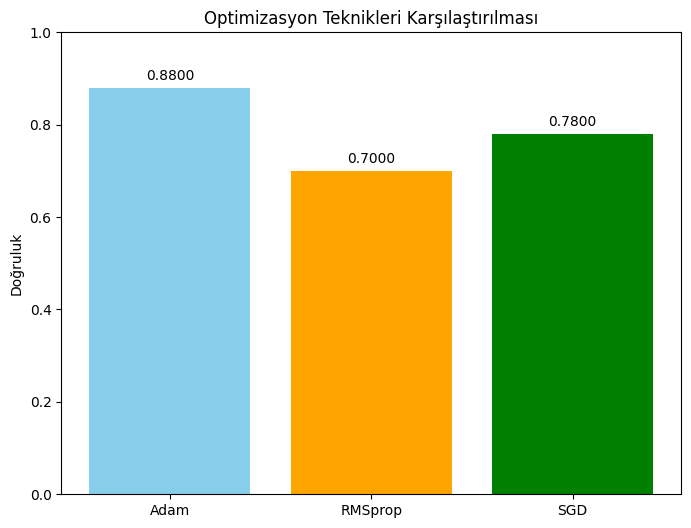

In [31]:
plt.figure(figsize=(8,6))
bars = plt.bar(results.keys(), results.values(), color=['skyblue','orange','green'])
plt.title('Optimizasyon Teknikleri Karşılaştırılması')
plt.ylabel('Doğruluk')
plt.ylim(0,1)
for bar, acc in zip(bars, results.values()):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
             f'{acc:.4f}', ha='center', va='bottom')
plt.show()


# Proje Sonuçları

- `test_accuracy`: Temel CNN modelinin test setindeki doğruluğu.  
- `results`: Farklı optimizasyon algoritmalarının test doğrulukları.  
- `max(results, key=results.get)`: En iyi performansı veren optimizer ve doğruluk değeri.  

> Bu bölüm, modelin genel performansını hızlıca özetler ve hangi optimizer ile en iyi sonucu elde ettiğimizi gösterir.


In [32]:
print("="*50)
print("BEYİN MRI PROJE SONUÇLARI")
print("="*50)
print(f"Temel CNN Model Doğruluğu: {test_accuracy:.4f}")
print(f"En iyi optimizer: {max(results, key=results.get)} "
      f"({max(results.values()):.4f})")
print("="*50)


BEYİN MRI PROJE SONUÇLARI
Temel CNN Model Doğruluğu: 0.7451
En iyi optimizer: Adam (0.8800)
